In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator

In [4]:
train_path = "/kaggle/input/standard-ocr-dataset/data/training_data/"
test_path  = "/kaggle/input/standard-ocr-dataset/data/testing_data/"

In [5]:
# Get lables
labels = os.listdir(train_path)

In [6]:
# Define constants
IMG_SHAPE = (64, 64)
INPUT_SHAPE = (IMG_SHAPE[0], IMG_SHAPE[1], 3)
BATCH_SIZE = 32
EPOCHS = 10
loss = 'categorical_crossentropy'

In [7]:
# Get all image data
def get_data(filepath):
    images = []
    classes = []
    
    labels = os.listdir(filepath)
    for image_class in labels:
        ims = os.listdir(os.path.join(filepath, image_class))
        for i in range(0, len(ims)):
            im = cv2.imread(os.path.join(filepath, image_class, ims[i]))
            if im is not None:
                im = cv2.resize(im, IMG_SHAPE)
                im = np.array(im, dtype=np.float32)
                im = im / 255
                images.append(im)
                classes.append(image_class)            
            else:
                print(i, ims[i], image_class)
        
    return np.array(images), np.array(classes)

In [8]:
# Get test and train data
train_X, train_Y = get_data(train_path)
test_X, test_Y = get_data(test_path)

In [9]:
train_X.shape

(20628, 64, 64, 3)

In [10]:
train_X.shape[0] == train_Y.shape[0] and test_X.shape[0] == test_Y.shape[0]

True

In [11]:
# One hot encode labels
le = LabelEncoder()
train_Y = le.fit_transform(train_Y)

Text(0.5, 1.0, 'Label: 10')

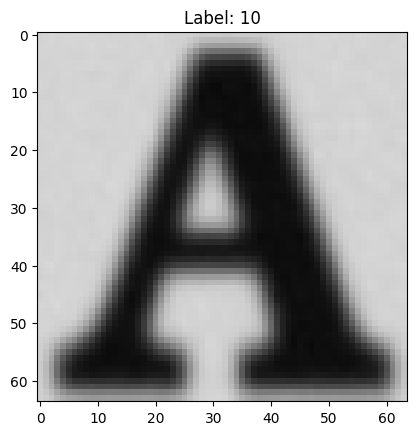

In [12]:
# Check image
test_image = 12022
plt.imshow(train_X[test_image], cmap="gray")
plt.title(f"Label: {train_Y[test_image]}")

In [13]:
# Data augmentation object
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,  # Don't flip for characters
    vertical_flip=False,  # Don't flip for characters
    fill_mode='nearest'
)

In [14]:
# Augment all the original data and place back into np arrays
augmented_arr_X = []
augmented_arr_Y = []
for i in range(len(train_X)):
  image_expanded = np.expand_dims(train_X[i], axis=0)
  augmented_images = [datagen.flow(image_expanded, batch_size=1).next()[0] for _ in range(5)]
  augmented_arr_X.append(augmented_images)
  augmented_arr_Y += [train_Y[i] for j in range(5)]
new_images = []
for row in augmented_arr_X:
  for image in row:
    new_images.append(image)

X = np.array(new_images)
Y = np.array(augmented_arr_Y)

In [15]:
X.shape

(103140, 64, 64, 3)

In [16]:
Y.shape

(103140,)

In [17]:
# Shuffle data
train_X, train_Y = shuffle(X, Y, random_state=42)

In [18]:
# Define model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size=(3,3),  activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size=(3,3),  activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=36, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)          0

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [21]:
history = model.fit(train_X, train_Y, validation_split=0.2, epochs=EPOCHS)

Epoch 1/10
2579/2579 [==============================] - 162s 62ms/step - loss: 0.5790 - accuracy: 0.8242 - val_loss: 0.2445 - val_accuracy: 0.9215
Epoch 2/10
2579/2579 [==============================] - 158s 61ms/step - loss: 0.2050 - accuracy: 0.9312 - val_loss: 0.1932 - val_accuracy: 0.9333
Epoch 3/10
2579/2579 [==============================] - 156s 61ms/step - loss: 0.1522 - accuracy: 0.9469 - val_loss: 0.1396 - val_accuracy: 0.9536
Epoch 4/10
2579/2579 [==============================] - 157s 61ms/step - loss: 0.1204 - accuracy: 0.9573 - val_loss: 0.1416 - val_accuracy: 0.9516
Epoch 5/10
2579/2579 [==============================] - 157s 61ms/step - loss: 0.1015 - accuracy: 0.9640 - val_loss: 0.1138 - val_accuracy: 0.9630
Epoch 6/10
2579/2579 [==============================] - 155s 60ms/step - loss: 0.0894 - accuracy: 0.9670 - val_loss: 0.1259 - val_accuracy: 0.9576
Epoch 7/10
2579/2579 [==============================] - 156s 60ms/step - loss: 0.0796 - accuracy: 0.9705 - val_loss: 0

In [22]:
# Shuffle test data
test_X, test_Y = shuffle(test_X, test_Y, random_state=42)

In [23]:
# One hot encode test data
le = LabelEncoder()
test_Y = le.fit_transform(test_Y)

In [24]:
# Check accuracy
test_loss, test_accuracy = model.evaluate(test_X, test_Y)

32/32 [==============================] - 1s 16ms/step - loss: 0.0277 - accuracy: 0.9871


In [25]:
print(f"Test accuracy: {test_accuracy*100}% \t Test loss: {test_loss}")

Test accuracy: 98.71031641960144% 	 Test loss: 0.027662869542837143


In [26]:
# Get the keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

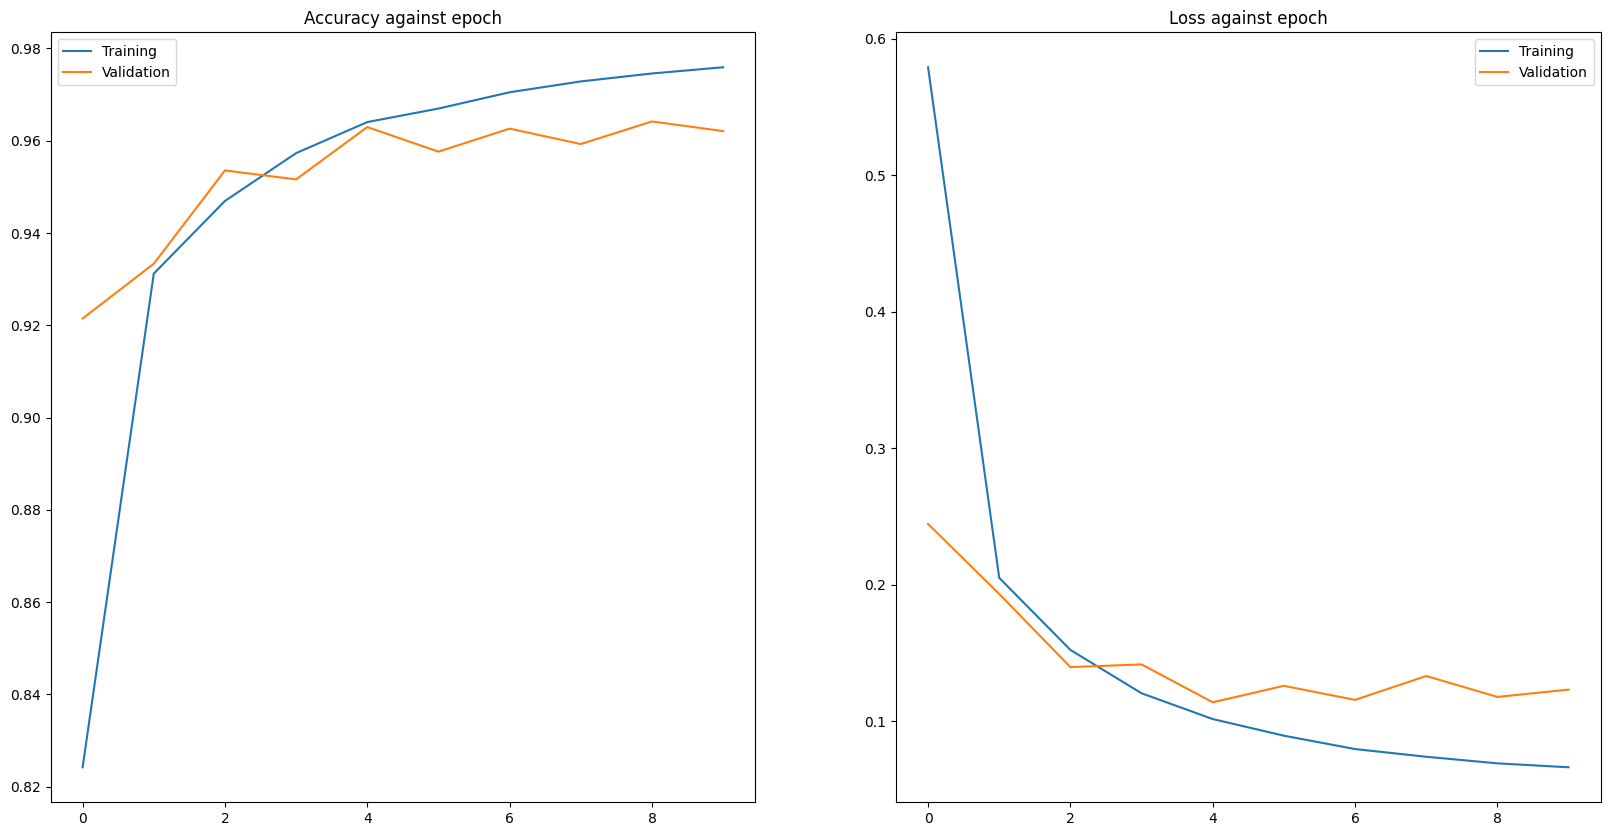

In [27]:
# Plot val and train accuracy and loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Adjust figsize as needed
labels = ["Training", "Validation"]
# Plot accuracy data
axes[0].set_title("Accuracy against epoch")
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].legend(labels)
# Plot loss data
axes[1].set_title("Loss against epoch")
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(labels)

plt.show()

In [28]:
test_Y = le.inverse_transform(test_Y)
test_Y_pred = model.predict(test_X)

32/32 [==============================] - 1s 16ms/step


In [29]:
x = np.argmax(test_Y_pred, axis=1)
x = le.inverse_transform(x)

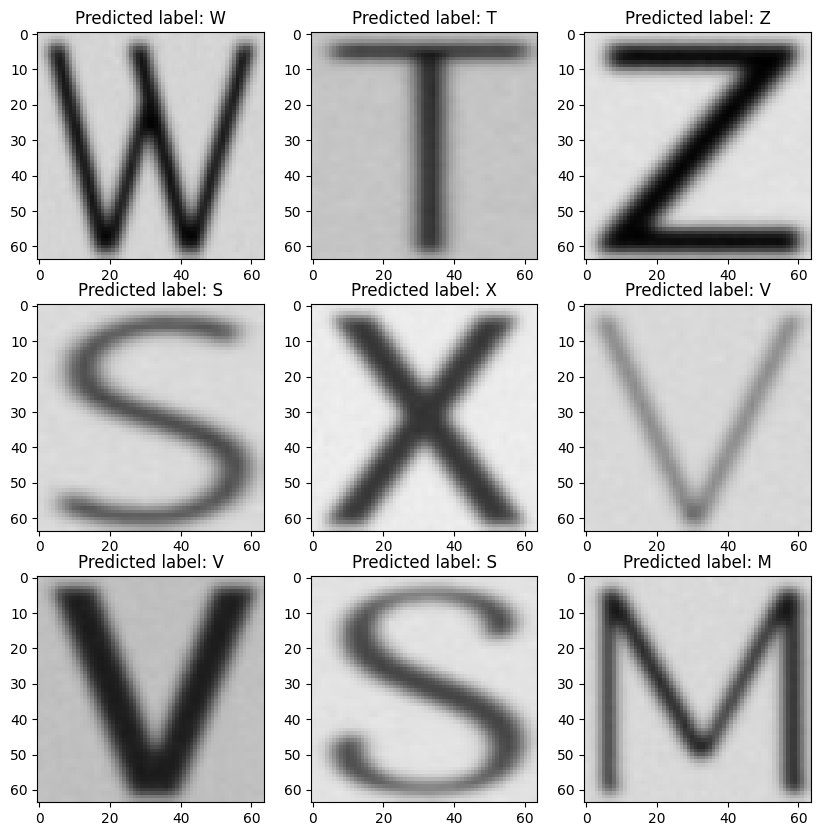

In [30]:
# Look at sample of 10 test data items
rows, cols = 3, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))  # Adjust figsize as needed
axes = axes.flatten()
# Go through 
for i in range(rows * cols):
    axes[i].imshow(test_X[i])
    axes[i].set_title(f"Predicted label: {x[i]}")
plt.show()

In [31]:
model.save('my_model.keras')